# Environment setup

# Import neccessary libraries

In [56]:
import os
from datetime import date, timedelta

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [63]:
class Config: 
    epoch =  300
    lr =  0.001 
    hidden = 64
    batch_size = 8 
    dropout = 0.5
    window =  7         # Size of window for features.
    graph_window = 7    # Size of window for graphs in MPNN LSTM.
    recur = False
    early_stop = 100
    start_exp = 15      # The first day to start the predictions.
    ahead = 14          # The number of days ahead of the train set the predictions should reach.
    sep =  10           # Seperator for validation and train set.

config = Config()

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Utils

In [54]:
def moving_average(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [15]:
def generate_graphs_tmp(src, dates,country):
    Gs = []
    for date in dates:
        filename = f"{country}_{date}.csv"
        filename = os.path.join(src, "graphs", filename)
        d = pd.read_csv(filename,header=None)
        G = nx.DiGraph()
        nodes = set(d[0].unique()).union(set(d[1].unique()))
        G.add_nodes_from(nodes)

        for row in d.iterrows():
            G.add_edge(row[1][0], row[1][1], weight=row[1][2])
        Gs.append(G)
        
    return Gs

def generate_new_features(Gs, labels, dates, window=7, scaled=False):
    """
    Generate node features
    Features[1] contains the features corresponding to y[1]
    e.g. if window = 7, features[7]= day0:day6, y[7] = day7
    if the window reaches before 0, everything is 0, so features[3] = [0,0,0,0,day0,day1,day2], y[3] = day3
    """
    features = list()
    
    labs = labels.copy()
    nodes = Gs[0].nodes()
  

    #--- one hot encoded the region
    #departments_name_to_id = dict()
    #for node in nodes:
    #    departments_name_to_id[node] = len(departments_name_to_id)

    #n_departments = len(departments_name_to_id)
    
    #print(n_departments)
    for idx,G in enumerate(Gs):
        #  Features = population, coordinates, d past cases, one hot region
        
        H = np.zeros([G.number_of_nodes(),window]) #+3+n_departments])#])#])
        me = labs.loc[:, dates[:(idx)]].mean(1)
        sd = labs.loc[:, dates[:(idx)]].std(1)+1

        ### enumarate because H[i] and labs[node] are not aligned
        for i,node in enumerate(G.nodes()):
            #---- Past cases      
            if(idx < window):# idx-1 goes before the start of the labels
                if(scaled):
                    #me = np.mean(labs.loc[node, dates[0:(idx)]]
                    H[i,(window-idx):(window)] = (labs.loc[node, dates[0:(idx)]] - me[node])/ sd[node]
                else:
                    H[i,(window-idx):(window)] = labs.loc[node, dates[0:(idx)]]

            elif idx >= window:
                if(scaled):
                    H[i,0:(window)] =  (labs.loc[node, dates[(idx-window):(idx)]] - me[node])/ sd[node]
                else:
                    H[i,0:(window)] = labs.loc[node, dates[(idx-window):(idx)]]
      
            
        features.append(H)
        
    return features

def read_meta_datasets(window, src=r'data'):
    meta_labs = []
    meta_graphs = []
    meta_features = []
    meta_y = []

    #------------------ Italy
    data_dir = os.path.join(src, "Italy")
    label_dir = os.path.join(data_dir, "italy_labels.csv")
    labels = pd.read_csv(label_dir)
    del labels["id"]
    labels = labels.set_index("name")

    sdate = date(2020, 2, 24)
    edate = date(2020, 5, 12)
    delta = edate - sdate
    dates = [sdate + timedelta(days=i) for i in range(delta.days+1)]
    dates = [str(date) for date in dates]
    
    
    Gs = generate_graphs_tmp(data_dir, dates,"IT") 
    labels = labels.loc[list(Gs[0].nodes()),:]
    labels = labels.loc[:,dates]    
     
    meta_labs.append(labels)
    gs_adj = [nx.adjacency_matrix(kgs).toarray().T for kgs in Gs]

    meta_graphs.append(gs_adj)

    features = generate_new_features(Gs ,labels ,dates ,window)

    meta_features.append(features)

    y = list()
    for i,G in enumerate(Gs):
        y.append(list())
        for node in G.nodes():
            y[i].append(labels.loc[node,dates[i]])

    meta_y.append(y)

    
    
    #------------------------- Spain
    data_dir = os.path.join(src, "Spain")
    label_dir = os.path.join(data_dir,"spain_labels.csv")
    labels = pd.read_csv(label_dir)
    labels = labels.set_index("name")

    sdate = date(2020, 3, 12)
    edate = date(2020, 5, 12)
    #--- series of graphs and their respective dates
    delta = edate - sdate
    dates = [sdate + timedelta(days=i) for i in range(delta.days+1)]
    dates = [str(date) for date in dates]
    
    
    
    Gs = generate_graphs_tmp(data_dir, dates,"ES")# 
    labels = labels.loc[list(Gs[0].nodes()),:]
    labels = labels.loc[:,dates]    #labels.sum(1).values>10
   
    meta_labs.append(labels)

    gs_adj = [nx.adjacency_matrix(kgs).toarray().T for kgs in Gs]

    meta_graphs.append(gs_adj)

    features = generate_new_features(Gs ,labels ,dates ,window )

    meta_features.append(features)

    y = list()
    for i,G in enumerate(Gs):
        y.append(list())
        for node in G.nodes():
            y[i].append(labels.loc[node,dates[i]])

    meta_y.append(y)

    
    
    #---------------- Britain
    data_dir = os.path.join(src,"England")
    label_dir = os.path.join(data_dir, "england_labels.csv")
    labels = pd.read_csv(label_dir)
    #del labels["id"]
    labels = labels.set_index("name")

    sdate = date(2020, 3, 13)
    edate = date(2020, 5, 12)
    #Gs = generate_graphs(dates)
    delta = edate - sdate
    dates = [sdate + timedelta(days=i) for i in range(delta.days+1)]
    dates = [str(date) for date in dates]

    
    Gs = generate_graphs_tmp(data_dir, dates,"EN")
    
    labels = labels.loc[list(Gs[0].nodes()),:]
    #print(labels.shape)
    labels = labels.loc[:,dates]    
    
    meta_labs.append(labels)

    gs_adj = [nx.adjacency_matrix(kgs).toarray().T for kgs in Gs]
    meta_graphs.append(gs_adj)

    features = generate_new_features(Gs ,labels ,dates ,window)
    meta_features.append(features)

    y = list()
    nodes_without_labels = set()
    for i,G in enumerate(Gs):
        y.append(list())
        for node in G.nodes():
            y[i].append(labels.loc[node,dates[i]])
    meta_y.append(y)

    #--- series of graphs and their respective dates
    #targets = produce_targets(dates, 'cases')
    
    
    #---------------- France
    data_dir = os.path.join(src,"France")
    label_dir = os.path.join(data_dir, "france_labels.csv")
    labels = pd.read_csv(label_dir)
    #del labels["id"]
    labels = labels.set_index("name")

    sdate = date(2020, 3, 10)
    edate = date(2020, 5, 12)
    
    #--- series of graphs and their respective dates
    delta = edate - sdate
    dates = [sdate + timedelta(days=i) for i in range(delta.days+1)]
    dates = [str(date) for date in dates]
    labels = labels.loc[:,dates]    #labels.sum(1).values>10

    
    
    Gs = generate_graphs_tmp(data_dir, dates,"FR")
    gs_adj = [nx.adjacency_matrix(kgs).toarray().T for kgs in Gs]

    labels = labels.loc[list(Gs[0].nodes()),:]
    
    meta_labs.append(labels)

    meta_graphs.append(gs_adj)

    features = generate_new_features(Gs ,labels ,dates ,window)

    meta_features.append(features)

    y = list()
    for i,G in enumerate(Gs):
        y.append(list())
        for node in G.nodes():
            y[i].append(labels.loc[node,dates[i]])

    meta_y.append(y)
    
    return meta_labs, meta_graphs, meta_features, meta_y

In [75]:
def generate_new_batches(Gs, features, y, idx, graph_window, shift, batch_size, device, test_sample):
    """
    Generate batches for graphs for MPNN
    """

    N = len(idx)
    n_nodes = Gs[0].shape[0]
    #n_nodes = Gs[0].number_of_nodes()
  
    adj_lst = list()
    features_lst = list()
    y_lst = list()

    for i in range(0, N, batch_size):
        n_nodes_batch = (min(i+batch_size, N)-i)*graph_window*n_nodes
        step = n_nodes*graph_window

        adj_tmp = list()
        features_tmp = np.zeros((n_nodes_batch, features[0].shape[1]))

        y_tmp = np.zeros((min(i+batch_size, N)-i)*n_nodes)

        #fill the input for each batch
        for e1,j in enumerate(range(i, min(i+batch_size, N) )):
            val = idx[j]

            # Feature[10] containes the previous 7 cases of y[10]
            for e2,k in enumerate(range(val-graph_window+1,val+1)):
                
                adj_tmp.append(Gs[k-1].T)  
                # each feature has a size of n_nodes
                features_tmp[(e1*step+e2*n_nodes):(e1*step+(e2+1)*n_nodes),:] = features[k]#-features[val-graph_window-1]
            
            
            if(test_sample>0):
                #--- val is by construction less than test sample
                if(val+shift<test_sample):
                    y_tmp[(n_nodes*e1):(n_nodes*(e1+1))] = y[val+shift]
                    
                else:
                    y_tmp[(n_nodes*e1):(n_nodes*(e1+1))] = y[val]
                        
                        
            else:
                y_tmp[(n_nodes*e1):(n_nodes*(e1+1))] = y[val+shift]
        
        adj_tmp = sp.block_diag(adj_tmp)
        adj_lst.append(sparse_mx_to_torch_sparse_tensor(adj_tmp).to(device))
        features_lst.append(torch.FloatTensor(features_tmp).to(device))
        y_lst.append(torch.FloatTensor(y_tmp).to(device))

    return adj_lst, features_lst, y_lst

def generate_batches_lstm(n_nodes, y, idx, window, shift, batch_size, device,test_sample):
    """
    Generate batches for graphs for the LSTM
    """
    N = len(idx)
    features_lst = list()
    y_lst = list()
    adj_fake = list()
    
    for i in range(0, N, batch_size):
        n_nodes_batch = (min(i+batch_size, N)-i)*n_nodes*1
        #step = n_nodes#*window
        step = n_nodes*1

        adj_tmp = list()
        features_tmp = np.zeros((window, n_nodes_batch))#features.shape[1]))
        
        y_tmp = np.zeros((min(i+batch_size, N)-i)*n_nodes)
        
        for e1,j in enumerate(range(i, min(i+batch_size, N))):
            val = idx[j]
            
            # keep the past information from val-window until val-1
            for e2,k in enumerate(range(val-window,val)):
               
                if(k==0): 
                    features_tmp[e2, (e1*step):(e1*step+n_nodes)] = np.zeros([n_nodes])#features#[k]
                else:
                    features_tmp[e2, (e1*step):(e1*step+n_nodes)] = np.array(y[k])#.reshape([n_nodes,1])#

            if(test_sample>0):
                # val is by construction less than test sample
                if(val+shift<test_sample):
                    y_tmp[(n_nodes*e1):(n_nodes*(e1+1))] = y[val+shift]
                else:
                    y_tmp[(n_nodes*e1):(n_nodes*(e1+1))] = y[val]
                        
            else:
         
                y_tmp[(n_nodes*e1):(n_nodes*(e1+1))] = y[val+shift]       
         
        adj_fake.append(0)
        
        features_lst.append(torch.FloatTensor(features_tmp).to(device))
        y_lst.append( torch.FloatTensor(y_tmp).to(device))
        
    return adj_fake, features_lst, y_lst

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [76]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Dataset

## Criteria:

+ The start date is the earliest date for which we have both mobility data and data related to the number of cases available. 
+ Do not take into consideration regions that had less then 10 confirmed cases in total.


## Problems of the dataset:
+ The data is collected directly from mobile phones that have the Facebook application installed and the Location History setting enabled. 
+ Case reporting is often not consistent. 
+ Average can not indicate trends of the phenomenon in most region, since the maximum difference encountered between consecutive days is multiple times the average value. 

In [16]:
meta_labs, meta_graphs, meta_features, meta_y = read_meta_datasets(window=7)

## Italy EDA

In [22]:
idx = 0
labels = meta_labs[idx]
gs_adj = meta_graphs[idx]
features = meta_features[idx]
y = meta_y[idx]
n_samples= len(gs_adj)
nfeat = meta_features[0][0].shape[1]

n_nodes = gs_adj[0].shape[0]
print(n_nodes)

105


In [51]:
print('Labels are typed as:', type(labels))
print('Shape of labels:', labels.shape)

Labels are typed as: <class 'pandas.core.frame.DataFrame'>
Shape of labels: (105, 79)


In [48]:
print('Number of temporal graph:', len(gs_adj))
print('Shape for each graph:', gs_adj[0].shape)

Number of temporal graph: 79
Shape for each graph: (105, 105)


In [49]:
print('Type of features:', type(features))
print('Number of features:', len(features))
print('Shape of each feature:', features[0].shape)

Type of features: <class 'list'>
Number of features: 79
Shape of each feature: (105, 7)


In [55]:
total_label_per_region = labels.sum(axis=1)
total_label_per_day = labels.sum(axis=0)

Text(0, 0.5, 'Cases recorded')

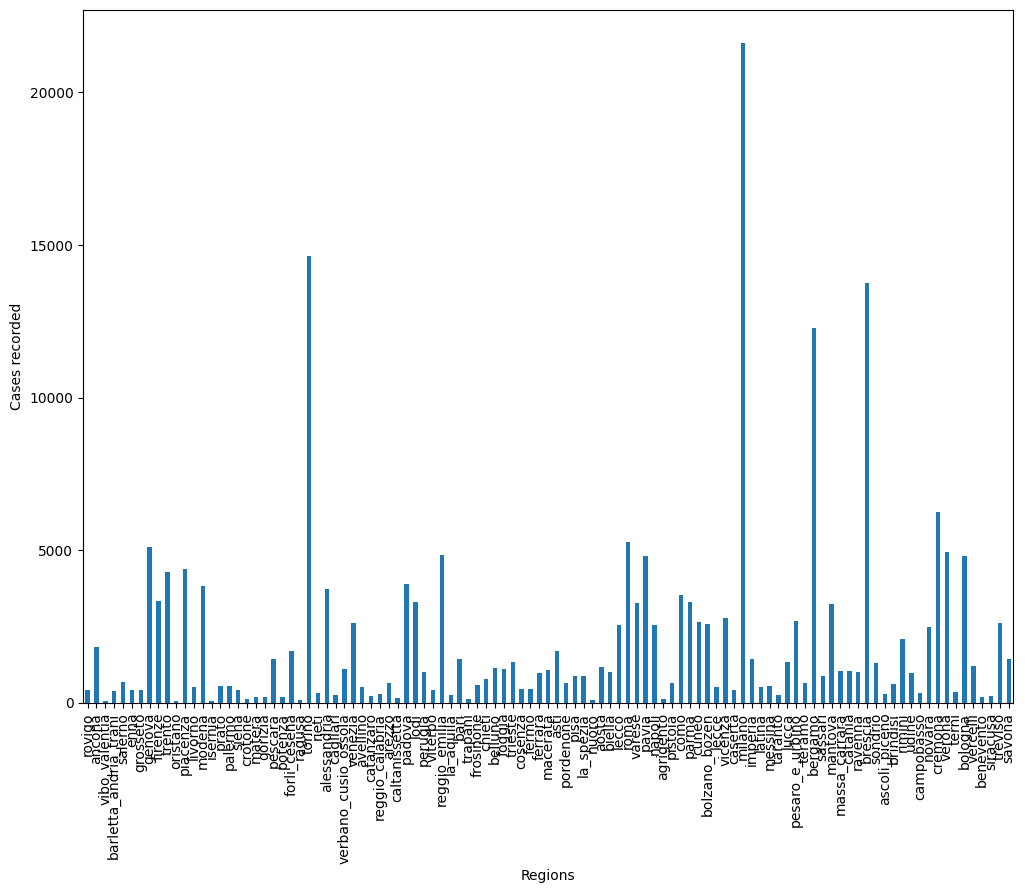

In [57]:
plt.figure(figsize=(12, 9))
total_label_per_region.plot.bar(x=total_label_per_region.index, 
                                y=total_label_per_region)
plt.xlabel('Regions')
plt.ylabel('Cases recorded')

Text(0, 0.5, 'Cases recorded')

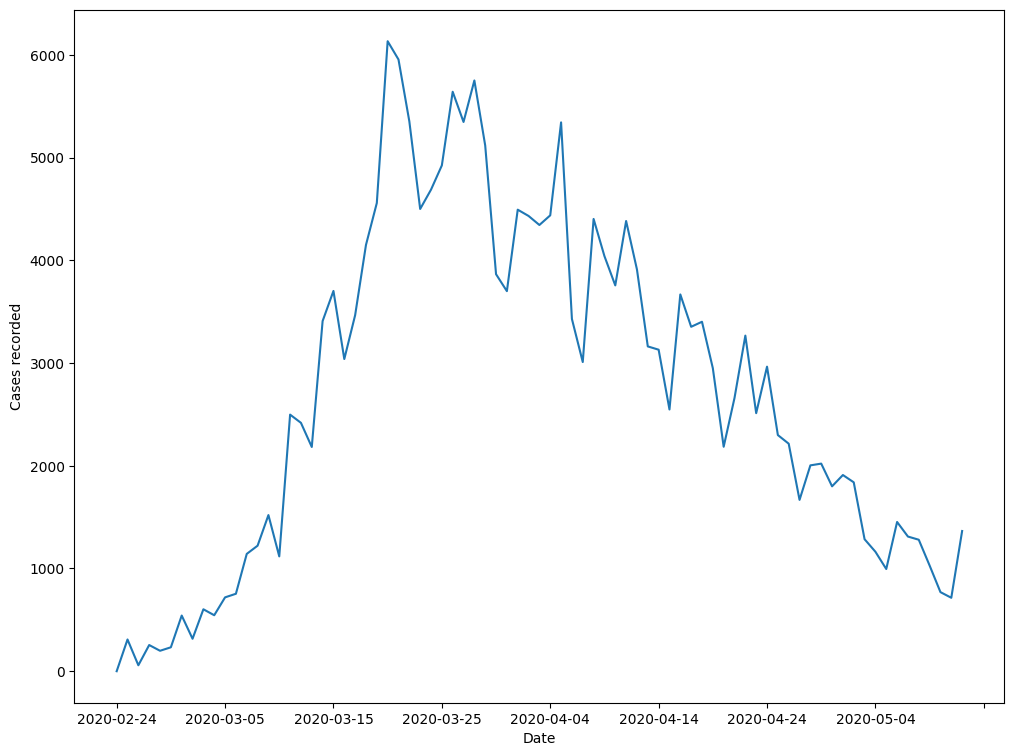

In [58]:
plt.figure(figsize=(12, 9))
total_label_per_day.plot(kind='line',
                         x=total_label_per_day.index, 
                         y=total_label_per_day, 
                         label='Infected')
plt.xlabel('Date')
plt.ylabel('Cases recorded')

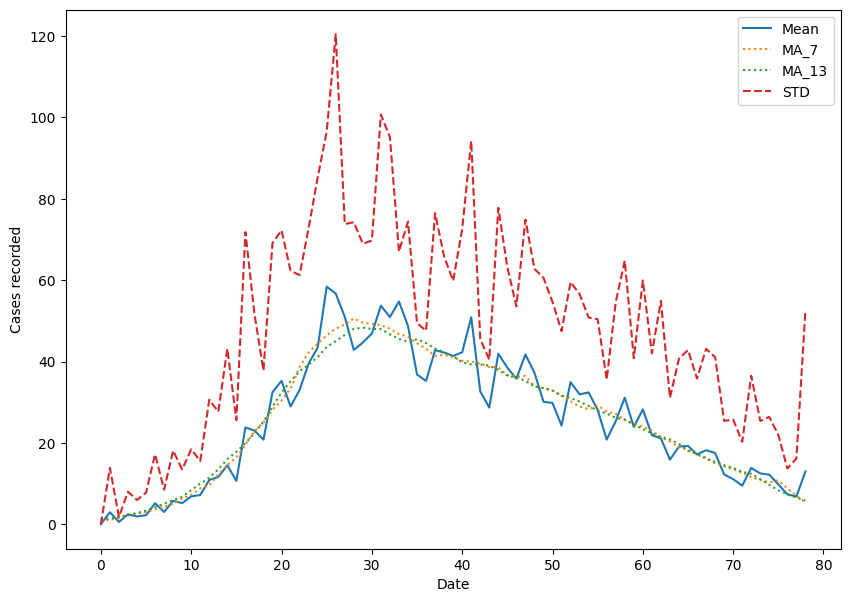

In [59]:
lbs_m_7 = moving_average(labels.mean(), 7)
lbs_m_13 = moving_average(labels.mean(), 13)

plt.figure(figsize=(10, 7))
plt.plot(range(len(total_label_per_day)), labels.mean(), label='Mean', linestyle='-')
plt.plot(range(len(total_label_per_day)), lbs_m_7, label='MA_7', linestyle=':')
plt.plot(range(len(total_label_per_day)), lbs_m_13, label='MA_13', linestyle='dotted')
plt.plot(range(len(total_label_per_day)), labels.std(), label='STD', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Cases recorded')
plt.legend()

# Model architecture

## LSTM

In [73]:
class LSTM(nn.Module):
    def __init__(self, nfeat, nhid, n_nodes, window, dropout,batch_size, recur):
        super().__init__()
        self.nhid = nhid
        self.n_nodes = n_nodes
        self.nout = n_nodes
        self.window = window
        self.nb_layers= 2

        self.nfeat = nfeat
        self.recur = recur
        self.batch_size = batch_size
        self.lstm = nn.LSTM(nfeat, self.nhid, num_layers=self.nb_layers)

        self.linear = nn.Linear(nhid, self.nout)
        self.cell = ( nn.Parameter(nn.init.xavier_uniform_(torch.Tensor(self.nb_layers, self.batch_size, self.nhid).type(torch.FloatTensor).cuda()),requires_grad=True))

        self.hidden_cell = (torch.zeros(2,self.batch_size,self.nhid).to(device),torch.zeros(2,self.batch_size,self.nhid).to(device))
        # nn.Parameter(nn.init.xavier_uniform_(torch.Tensor(self.nb_layers, self.batch_size, self.nhid).type(torch.FloatTensor).cuda()),requires_grad=True)


    def forward(self, adj, features):
        #adj is 0 here
        #print(features.shape)
        features = features.view(self.window,-1, self.n_nodes)#.view(-1, self.window, self.n_nodes, self.nfeat)
        #print(features.shape)
        #print("----")


        #------------------
        if(self.recur):
            #print(features.shape)
            #self.hidden_cell =
            try:
                lstm_out, (hc,self.cell) = self.lstm(features,(torch.zeros(self.nb_layers,self.batch_size,self.nhid).cuda(),self.cell))
                # = (hc,cn)
            except:
                #hc = self.hidden_cell[0][:,0:features.shape[1],:].contiguous().view(2,features.shape[1],self.nhid)
                hc = torch.zeros(self.nb_layers,features.shape[1],self.nhid).cuda()
                cn = self.cell[:,0:features.shape[1],:].contiguous().view(2,features.shape[1],self.nhid)
                lstm_out, (hc,cn) = self.lstm(features,(hc,cn))
        else:
        #------------------
            lstm_out, (hc,cn) = self.lstm(features)#, self.hidden_cell)#self.hidden_cell

        predictions = self.linear(lstm_out)#.view(self.window,-1,self.n_nodes)#.view(self.batch_size,self.nhid))#)
        #print(predictions.shape)
        return predictions[-1].view(-1)


In [72]:
lstm_features = 1*n_nodes
lstm = LSTM(nfeat=lstm_features, nhid=config.hidden, n_nodes=n_nodes, 
            window=config.window, dropout=config.dropout, 
            batch_size = config.batch_size, recur=config.recur).to(device)
lstm

C:\Users\ABC\AppData\Local\Temp\ipykernel_19672\1457455679.py:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.Parameter(nn.init.xavier_uniform(torch.Tensor(self.nb_layers, self.batch_size, self.nhid).type(torch.FloatTensor).cuda()),requires_grad=True)


LSTM(
  (lstm): LSTM(105, 64, num_layers=2)
  (linear): Linear(in_features=64, out_features=105, bias=True)
)

## MPNN

In [61]:
class MPNN(nn.Module):
    def __init__(self, nfeat, nhid, nout, dropout):
        super(MPNN, self).__init__()
        #self.n_nodes = n_nodes

        #self.batch_size = batch_size
        self.nhid = nhid


        self.conv1 = GCNConv(nfeat, nhid)
        self.conv2 = GCNConv(nhid, nhid)
        self.bn1 = nn.BatchNorm1d(nhid)
        self.bn2 = nn.BatchNorm1d(nhid)

        self.fc1 = nn.Linear(nfeat+2*nhid, nhid )
        self.fc2 = nn.Linear(nhid, nout)
        #self.bn3 = nn.BatchNorm1d(nhid)
        #self.bn4 = nn.BatchNorm1d(nhid)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

        #nn.init.zeros_(self.conv1.weight)
        #nn.init.zeros_(self.conv2.weight)
        #nn.init.zeros_(self.fc1.weight)
        #nn.init.zeros_(self.fc2.weight)


    def forward(self, adj, x):
        lst = list()
        #print(x.shape)
        #print(adj.shape)
        weight = adj.coalesce().values()
        adj = adj.coalesce().indices()

        #lst.append(ident)

        #x = x[:,mob_feats]
        #x = xt.index_select(1, mob_feats)
        lst.append(x)

        x = self.relu(self.conv1(x,adj,edge_weight=weight))
        #print(x)
        #print(x.shape)
        x = self.bn1(x)
        x = self.dropout(x)
        lst.append(x)

        x = self.relu(self.conv2(x, adj,edge_weight=weight))
        #print(x.shape)
        x = self.bn2(x)
        x = self.dropout(x)
        lst.append(x)


        x = torch.cat(lst, dim=1)

        x = self.relu(self.fc1(x))
        #x = self.bn3(x)
        x = self.dropout(x)

        x = self.relu(self.fc2(x)).squeeze() #
        #x = self.bn4(x)

        x = x.view(-1)

        return x

## MPNN + LSTM

In [74]:
class MPNN_LSTM(nn.Module):
    def __init__(self, nfeat, nhid, nout, n_nodes, window, dropout):
        super(MPNN_LSTM, self).__init__()
        self.window = window
        self.n_nodes = n_nodes
        #self.batch_size = batch_size
        self.nhid = nhid
        self.nfeat = nfeat
        self.conv1 = GCNConv(nfeat, nhid)
        self.conv2 = GCNConv(nhid, nhid)

        self.bn1 = nn.BatchNorm1d(nhid)
        self.bn2 = nn.BatchNorm1d(nhid)

        self.rnn1 = nn.LSTM(2*nhid, nhid, 1)
        self.rnn2 = nn.LSTM(nhid, nhid, 1)

        #self.fc1 = nn.Linear(2*nhid+window*nfeat, nhid)
        self.fc1 = nn.Linear(2*nhid+window*nfeat, nhid)
        self.fc2 = nn.Linear( nhid, nout)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()


    def forward(self, adj, x):
        lst = list()
       # print("--------------------")
        weight = adj.coalesce().values()
        adj = adj.coalesce().indices()
       # print(x.shape)
        skip = x.view(-1,self.window,self.n_nodes,self.nfeat)#self.batch_size
       # print(skip.shape)
        skip = torch.transpose(skip, 1, 2).reshape(-1,self.window,self.nfeat)#self.batch_size*self.n_nodes

        x = self.relu(self.conv1(x, adj,edge_weight=weight))
        x = self.bn1(x)
        x = self.dropout(x)
        lst.append(x)

        x = self.relu(self.conv2(x, adj,edge_weight=weight))
        x = self.bn2(x)
        x = self.dropout(x)
        lst.append(x)

        x = torch.cat(lst, dim=1)

        #--------------------------------------
        #print(x.shape)
        x = x.view(-1, self.window, self.n_nodes, x.size(1))
        #print(x.shape)
        #print(x.shape)
        x = torch.transpose(x, 0, 1)
        x = x.contiguous().view(self.window, -1, x.size(3))#self.batch_size*self.n_nodes

        #print(x.shape)
        #print("------")
        x, (hn1, cn1) = self.rnn1(x)


        out2, (hn2,  cn2) = self.rnn2(x)

        #print(self.rnn2._all_weights)
        x = torch.cat([hn1[0,:,:],hn2[0,:,:]], dim=1)
        #print(skip.shape)
        #print(x.shape)
        #skip = skip.view(skip.size(0),-1)
        skip = skip.reshape(skip.size(0),-1)
        #print(x.shape)
        #print(skip.shape)

        x = torch.cat([x,skip], dim=1)
        #--------------------------------------
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x)).squeeze()
        x = x.view(-1)
       # print("--------------------")
        return x

# Experiments

## Assumptions: 
1. People that use Facebook on their mobile phones with Location History enabled *constitute a uniform random sample* of the general population. 
2. The *number of cases* in a region *reported* by the authorities is *a representative sample* of the number of people that have been *actually infected* by the virus.
3. The *more people move* from one region to another or within a region, *the higher the probability* that people in the receiving region are *infected by the virus*.

## LSTM

## GNN + LSTM

# Application